Exemple de regression logistique
================================
Logistic Regression with Mini-Batch Gradient Descent using TensorFlow
---------------------------------------------------------------------

Une regression logistique à pour objectif de fournir une probabilité d'appartenance à une classe.  
X contient des caractéristiques  
y contient la probabilité d'appartenance (1 ou 0)

**Principe :**  
On va rechercher une valeur de $\theta$ tel que la regression linéaire $\theta^{T}X$ puisse servir à calculer notre probabilité :  

$\hat{p} = h_\theta(X) = \sigma(\theta^T{X})$  

Où $\sigma$ est la fonction logistique (logit), typiquement une fonction sigmoïde (en S) :  

$
\sigma(t) = \dfrac{1}{1 + \exp(-t)}
$  

La valeur prédite $\hat{y}$ sera alors calculée de la manière suivante :

$
\hat{y} =
\begin{cases}
  0 & \text{if } \hat{p} < 0.5 \\
  1 & \text{if } \hat{p} \geq 0.5
\end{cases}
$

**Calcul du coût de la régression :**  
Pour une observation d'entrainement x, le coût peut être calculé comme suit :  

$
c(\theta) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1 \\
  -\log(1 - \hat{p}) & \text{if } y = 0
\end{cases}
$

La fonction de coût de la regression (perte logistique ou *log loss*) sur l'ensemble du jeu d'apprentissage peut s'écrire de la manière suivante :  

$
J(\theta) = -\dfrac{1}{m} \sum_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$




In [1]:
import numpy as np
import sklearn as sl
from sklearn import metrics
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import os

import deepmods.notebook as ooo

ooo.init(id='08.2', save_figs=True)



Deepmod by pjluc 2019
  Version          : 0.4.1
  Run time         : Wednesday 25 September 2019, 14:37:32
  Run directory    : ./run/lab-08.2
  Save figs        : True
  Matplotlib style : deepmods/talk.mplstyle
  Hide warning     : True

TensorFlow version :  1.14.0
Keras version      :  2.2.4-tf

Init done.


In [2]:

# Affichage de quelques informations concernant un vecteur
#
def vector_infos(name,V):
    with np.printoptions(precision=4, suppress=True):
        print("{:16} : ndim={}  shape={:10}  Moyenne = {}  Ecart-type = {}".format( name,V.ndim, str(V.shape), V.mean(axis=0), V.std(axis=0)))
        #print('Exemple: \n',V[0:5])

# Renvoi un jeu de donnée pour un batch
#
def random_batch(X_train, y_train, batch_size):
    indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

1/ Paramètres
-------------

In [3]:
data_size      = 1000       # Nombre de données
data_cols      = 2          # Nombre de colonnes
data_noise     = 0.2
test_ratio     = 0.2        # Ratio des données de tests 
random_seed    = 123

learning_rate  = 0.01       # Rythme d'apprentissage
n_epochs       = 1000
batch_size     = 50

epsilon        = 1e-7       # Pour éviter des débordement sur certains calculs (log())

learning_rate2 = 0.01       # Pour la version 2
n_epochs2      = 6000
batch_size2    = 50


2/ Récupération / création des données
--------------------------------------
Les données sont ici totalement fabriquées ;-)

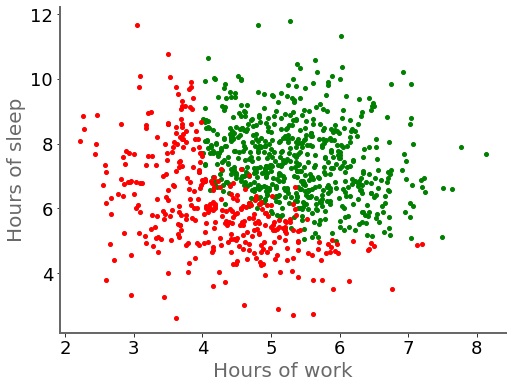

Dataset X        : ndim=2  shape=(1000, 2)   Moyenne = [4.9446 6.9893]  Ecart-type = [0.9956 1.466 ]
Dataset y        : ndim=1  shape=(1000,)     Moyenne = 0.636  Ecart-type = 0.481148625686492


In [15]:
hours_of_sleep_min = 5
hours_of_work_min  = 4
hours_of_game_max  = 3

def do_i_have_it(hours_of_work, hours_of_sleep):
    # ---- Have to sleep and work
    if hours_of_sleep < hours_of_sleep_min: return 0
    if hours_of_work < hours_of_work_min:   return 0
    # ---- Gameboy is not good for you
    hours_of_game = 24 - 10 - hours_of_sleep - hours_of_work + random.gauss(0,0.4)
    if hours_of_game > hours_of_game_max:   return 0
    # ---- Fine, you got it
    return 1

def make_students_dataset(size, noise):
    x = []
    y = []
    for i in range(size):
        w = random.gauss(5,1)
        s = random.gauss(7,1.5)
        r   = do_i_have_it(w,s)
        x.append([w,s])
        y.append(r)
    return (np.array(x), np.array(y))

X_data,y_data=make_students_dataset(data_size,data_noise)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,6)
ax.plot(X_data[y_data == 1, 0], X_data[y_data == 1, 1], 'go', markersize=4, label="y=1 (positive)")
ax.plot(X_data[y_data == 0, 0], X_data[y_data == 0, 1], 'ro', markersize=4, label="y=0 (negative)")
# plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlabel('Hours of work')
plt.ylabel('Hours of sleep')
ooo.save_fig('LogisticReg-a', svg=True)
plt.show()

vector_infos('Dataset X',X_data)
vector_infos('Dataset y',y_data)

2/ Préparation des données
--------------------------
On va :
- normaliser les données
- rajouter une colonne de 1 pour les biais
- verticaliser y_moons
- partager les données pour avoir :
  - un jeu d'apprentissage
  - un jeu de test

In [16]:
# ----- Normalisation des données
scaler = sl.preprocessing.StandardScaler()
X_scaled   = scaler.fit_transform(X_data)

# ----- Ajout de la colonne de 1
X_scaled_1 = np.c_[np.ones((data_size, 1)), X_scaled]

# ----- Verticalisation de y_moons
y_data_v = y_data.reshape(-1,1)

# ----- Partage des données
test_size = int(data_size * test_ratio)
X_train = X_scaled_1[:-test_size]
X_test  = X_scaled_1[-test_size:]
y_train = y_data_v[:-test_size]
y_test  = y_data_v[-test_size:]

vector_infos('X_scaled',X_scaled)
vector_infos('X_train',X_train)
vector_infos('y_train',y_train)
vector_infos('X_test',X_test)
vector_infos('y_test',y_test)

y_train_h = y_train.reshape(-1,) # nécessaire pour la visu.

X_scaled         : ndim=2  shape=(1000, 2)   Moyenne = [-0.  0.]  Ecart-type = [1. 1.]
X_train          : ndim=2  shape=(800, 3)    Moyenne = [ 1.     -0.0038 -0.0055]  Ecart-type = [0.     1.0151 0.9875]
y_train          : ndim=2  shape=(800, 1)    Moyenne = [0.6388]  Ecart-type = [0.4804]
X_test           : ndim=2  shape=(200, 3)    Moyenne = [1.     0.0154 0.0221]  Ecart-type = [0.     0.9372 1.0484]
y_test           : ndim=2  shape=(200, 1)    Moyenne = [0.625]  Ecart-type = [0.4841]


Train data


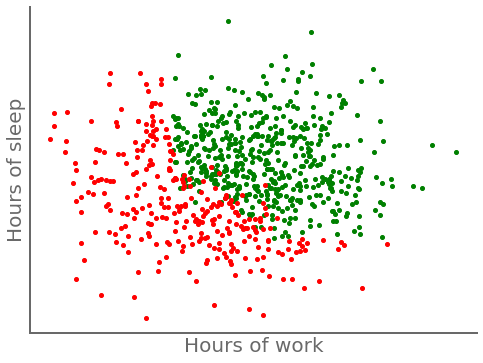

Test data


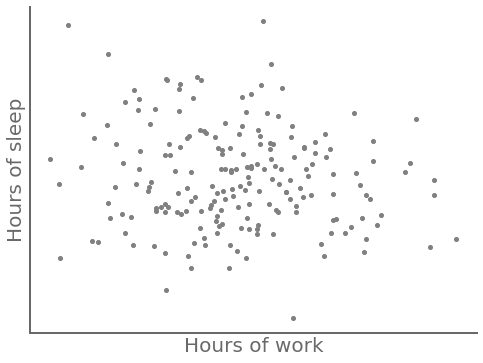

In [17]:
fig, axs = plt.subplots()
fig.set_size_inches(8,6)

# axs.set_title("Train data")
print("Train data")
axs.plot(X_train[y_train_h == 1, 1], X_train[y_train_h == 1, 2], 'o', color='green', markersize=4, label="Train / Positifs")
axs.plot(X_train[y_train_h == 0, 1], X_train[y_train_h == 0, 2], 'o', color='red',   markersize=4, label="Train / Négatifs")
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlabel('Hours of work')
plt.ylabel('Hours of sleep')
ooo.save_fig('LogisticReg-b',svg=True)
plt.show()


fig, axs = plt.subplots()
fig.set_size_inches(8,6)

# axs.set_title("Test data")
print("Test data")
axs.plot(X_test[:, 1], X_test[:, 2], 'o',color='gray', markersize=4, label="A classer !")
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlabel('Hours of work')
plt.ylabel('Hours of sleep')
ooo.save_fig('LogisticReg-c', svg=True)
plt.show()

Construction du modèle #1
-------------------------
**Modèle :**

In [18]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, data_cols + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

initializer = tf.random_uniform([data_cols + 1, 1], -1.0, 1.0, seed=random_seed)
theta = tf.Variable(initializer, name="theta")

logits = tf.matmul(X, theta, name="logits")

# Probabilité
#y_proba = tf.sigmoid(logits)
y_proba = 1 / (1 + tf.exp(-logits))

# Perte logistique
#loss = tf.losses.log_loss(y, y_proba)
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

# Optimisation du gradient
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

**Calcul du modèle :**

In [19]:
nb_batches = int(np.ceil(data_size / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs+1):
        for batch_index in range(nb_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val = loss.eval({X: X_test, y: y_test})
        
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 1.2533283
Epoch: 100 	Loss: 0.3106674
Epoch: 200 	Loss: 0.28309485
Epoch: 300 	Loss: 0.27574852
Epoch: 400 	Loss: 0.2735801
Epoch: 500 	Loss: 0.27165958
Epoch: 600 	Loss: 0.2728287
Epoch: 700 	Loss: 0.2730859
Epoch: 800 	Loss: 0.2731394
Epoch: 900 	Loss: 0.27550068
Epoch: 1000 	Loss: 0.27360386



**Evaluation du modèle :**  

Précision = Capacité à ne pas faire de faux positifs = $\frac{Tp}{Tp+Fp}$  
Rappel = Capacité à trouver les bon positifs = $\frac{Tp}{Tp+Fn}$  
Avec :  
$T_p$ (true positive) Réponse positive correcte  
$F_p$ (false positive) Réponse positive fausse  
$T_n$ (true negative) Réponse négative correcte  
$F_n$ (false negative) Réponse négative fausse  

Precision = 0.916    Recall = 0.960
Prédictions et erreurs


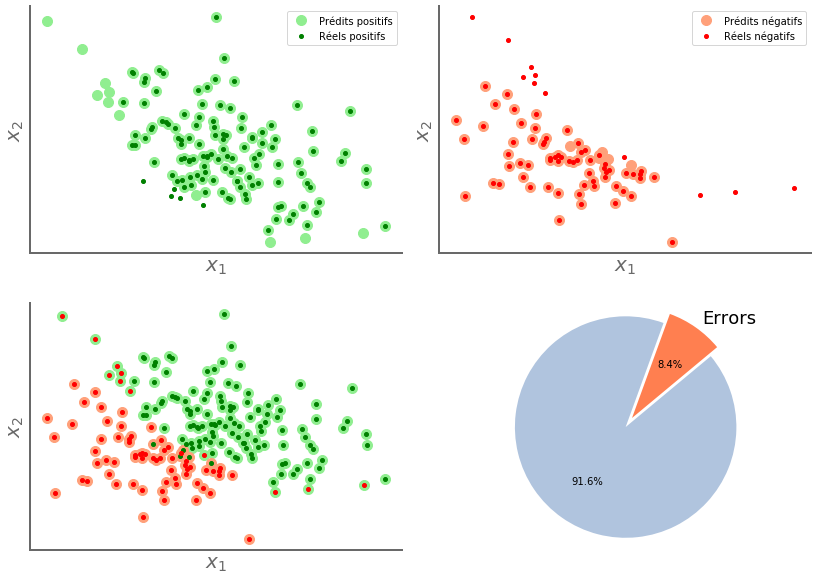

In [20]:
def show_results(y_proba_val, filename):
    y_pred = (y_proba_val >= 0.5)

    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)

    print("Precision = {:5.3f}    Recall = {:5.3f}".format(precision, recall))


    y_pred_1d = y_pred.reshape(-1) # Passage en 1D
    y_test_1d = y_test.reshape(-1)

    X_pred_positives = X_test[ y_pred_1d == True]   # items prédits    positifs
    X_real_positives = X_test[ y_test_1d == 1 ]     # items réellement positifs
    X_pred_negatives = X_test[ y_pred_1d == False]  # items prédits    négatifs
    X_real_negatives = X_test[ y_test_1d == 0 ]     # items réellement négatifs

    fig, axs = plt.subplots(2, 2)#, sharey=True, sharex=True)
    fig.subplots_adjust(wspace=.1,hspace=0.2)
    fig.set_size_inches(14,10)
#     fig.suptitle('Prédictions et erreurs', fontsize=16,y=0.92)
    print("Prédictions et erreurs")
    
    axs[0,0].plot(X_pred_positives[:,1], X_pred_positives[:,2], 'o',color='lightgreen', markersize=10, label="Prédits positifs")
    axs[0,0].plot(X_real_positives[:,1], X_real_positives[:,2], 'o',color='green',      markersize=4,  label="Réels positifs")
    axs[0,0].legend()
    axs[0,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[0,0].set_xlabel('$x_1$')
    axs[0,0].set_ylabel('$x_2$')


    axs[0,1].plot(X_pred_negatives[:,1], X_pred_negatives[:,2], 'o',color='lightsalmon', markersize=10, label="Prédits négatifs")
    axs[0,1].plot(X_real_negatives[:,1], X_real_negatives[:,2], 'o',color='red',        markersize=4,  label="Réels négatifs")
    axs[0,1].legend()
    axs[0,1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[0,1].set_xlabel('$x_1$')
    axs[0,1].set_ylabel('$x_2$')
    
    axs[1,0].plot(X_pred_positives[:,1], X_pred_positives[:,2], 'o',color='lightgreen', markersize=10, label="Prédits positifs")
    axs[1,0].plot(X_pred_negatives[:,1], X_pred_negatives[:,2], 'o',color='lightsalmon', markersize=10, label="Prédits négatifs")
    axs[1,0].plot(X_real_positives[:,1], X_real_positives[:,2], 'o',color='green',      markersize=4,  label="Réels positifs")
    axs[1,0].plot(X_real_negatives[:,1], X_real_negatives[:,2], 'o',color='red',        markersize=4,  label="Réels négatifs")
    axs[1,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[1,0].set_xlabel('$x_1$')
    axs[1,0].set_ylabel('$x_2$')

    axs[1,1].pie([precision,1-precision], explode=[0,0.1], labels=["","Errors"], 
                 autopct='%1.1f%%', shadow=False, startangle=70, colors=["lightsteelblue","coral"])
    axs[1,1].axis('equal')

    ooo.save_fig(filename, svg=True)
    plt.show()

show_results(y_proba_val, 'LogisticReg-d')


Amélioration du modèle #2
-------------------------
On va ajouter des paramètres : ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ et ${x_2}^3$  

$
X=
\begin{bmatrix}1 & x_{11} & x_{12} \\
\vdots & \dots\\
1 & x_{m1} & x_{m2}  \end{bmatrix}
\text{et }
X_{ng}=\begin{bmatrix}1 & x_{11} & x_{12} & x_{11}^2 & x_{12}^2& x_{11}^3 & x_{12}^3 \\
\vdots & & & \dots \\
1 & x_{m1} & x_{m2} & x_{m1}^2 & x_{m2}^2& x_{m1}^3 & x_{m2}^3 \end{bmatrix}
$

Note : `sklearn.preprocessing.PolynomialFeatures` peut faire ça pour vous 

In [21]:
X_train_enhanced = np.c_[X_train,
                         X_train[:, 1] ** 2,
                         X_train[:, 2] ** 2,
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        X_test[:, 1] ** 2,
                        X_test[:, 2] ** 2,
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]


In [22]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):

    n_inputs_including_bias = int(X.get_shape()[1])
    
    with tf.name_scope("logistic_regression"):
        
        # ----- Construction du modèle
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            # X.theta
            logits = tf.matmul(X, theta, name="logits")
            # Probabilité
            y_proba = tf.sigmoid(logits)
            
        with tf.name_scope("train"):
            # Perte logistique
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            # Descente de gradient
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate2)
            training_op = optimizer.minimize(loss)
            # Trace
            loss_summary = tf.summary.scalar('log_loss', loss)
            
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
        with tf.name_scope("save"):
            saver = tf.train.Saver(max_to_keep=4)
            
    return y_proba, loss, training_op, loss_summary, init, saver


**Construction du modèle**

In [23]:
tf.reset_default_graph()

log_dir = ooo.get_log_dir()
chk_dir = ooo.get_check_dir()

X = tf.placeholder(tf.float32, shape=(None, data_cols + 1 + 4), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

# Construction du modèle
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

# Enregistrement du modèle
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

log dir is         : ./run/lab-08.2/log/2019-09-25_14h38m52s
To run TensorBoard : # tensorboard --logdir="./run/lab-08.2/log"


**Calcul du modèle**

In [24]:
n_batches = int(np.ceil(data_size / batch_size2))

epoch_file  = chk_dir + "/epoch.last"
model_file  = chk_dir + "/model-ckpt"
model_final = chk_dir + "/model-final"

with tf.Session() as sess:
    
    # ----- Point de départ ? Checkpoint ou 0
    #
    if os.path.isfile(epoch_file):
        # Si epoch_file existe : On récupère l'époque et on restaure le checkpoint correspondant
        with open(epoch_file, "r") as f:
            epoch = int(f.read())
        saver.restore(sess, '{}-{}'.format(model_file,epoch))
        start_epoch=epoch+1
        print("Reprise de l'apprentissage à l'époque : ", start_epoch)
        print("Restauration du checkpoint            : ", chk_dir,'-',epoch)
    else:
        # epoch_file introuvable : On commence à 0
        start_epoch = 0
        sess.run(init)

    # ----- Ok, on y va...
    #
    for epoch in range(start_epoch, n_epochs2 + 1):
        
        for batch_index in range(n_batches):
            # Recupération du lot
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            # Apprentissage
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Calcul de la perte logistique et du log (en une seule fois)
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        # Enregistrement des logs
        file_writer.add_summary(summary_str, epoch)
        
        if epoch % 500 == 0:
            print('Epoch: {:6d}  Loss: {:8.4f}    checkpoint: {}-{}'.format(epoch,loss_val,model_file,epoch))
            # Sauvegarde d'un checkpoint
            saver.save(sess, model_file, global_step=epoch)
            # Sauvearde de l'epoch
            with open(epoch_file, "w") as f:
                f.write(str(epoch))

    # Sauvegarde du modèle final
    saver.save(sess, model_final)
    # Calcul des probabilités de l'échantillon test
    y_proba_val2 = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    # Supression de l'epoch_file
    os.remove(epoch_file)

Epoch:      0  Loss:   0.7885    checkpoint: ./run/lab-08.2/check/model-ckpt-0
Epoch:    500  Loss:   0.1769    checkpoint: ./run/lab-08.2/check/model-ckpt-500
Epoch:   1000  Loss:   0.1506    checkpoint: ./run/lab-08.2/check/model-ckpt-1000
Epoch:   1500  Loss:   0.1379    checkpoint: ./run/lab-08.2/check/model-ckpt-1500
Epoch:   2000  Loss:   0.1307    checkpoint: ./run/lab-08.2/check/model-ckpt-2000
Epoch:   2500  Loss:   0.1253    checkpoint: ./run/lab-08.2/check/model-ckpt-2500
Epoch:   3000  Loss:   0.1216    checkpoint: ./run/lab-08.2/check/model-ckpt-3000
Epoch:   3500  Loss:   0.1196    checkpoint: ./run/lab-08.2/check/model-ckpt-3500
Epoch:   4000  Loss:   0.1174    checkpoint: ./run/lab-08.2/check/model-ckpt-4000
Epoch:   4500  Loss:   0.1170    checkpoint: ./run/lab-08.2/check/model-ckpt-4500
Epoch:   5000  Loss:   0.1157    checkpoint: ./run/lab-08.2/check/model-ckpt-5000
Epoch:   5500  Loss:   0.1144    checkpoint: ./run/lab-08.2/check/model-ckpt-5500
Epoch:   6000  Loss:

Precision = 0.953    Recall = 0.976
Prédictions et erreurs


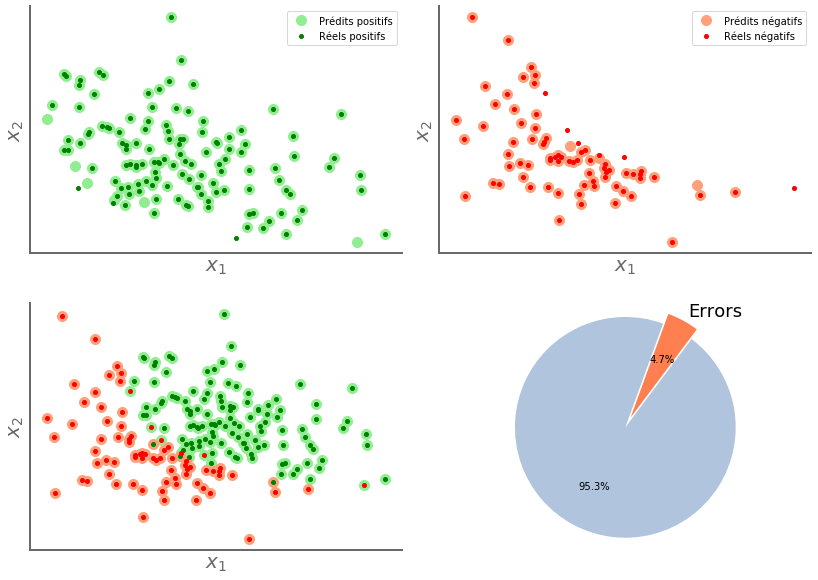

In [25]:
show_results(y_proba_val2, 'LogisticReg-e')